# Analyzing Trends in News Headlines
---

## Introduction
---

* Why I am doing this
    * Feels like I only see negative news, wanted to check if that's so
* Wanted to see if major celebrations effect the amount of negative news
* Wanted to see if there are any patterns in the amount of negative news
    * Time of day
    * Time of the mounth
* Wanted to analyze which country is mentioned the most in the news
* Wanted to analyze which president is mentioned the most in the news

Whenever I opened a homepage of a news website, I was greeted with at least five most recent news headlines. Usually, four out of five or even all the headlines carried a negative message, "a plain crashed", "new virus was found", "there is a nuclear threat", "a terrorist group has done something", etc. While I opened the homepage with a good mood, after reading a few negative headlines, my mood would instantlry change and I would get depressed, because so many bad things are happening to our society.

There were many posts written about why the headlines are dominated with negative news, some say it is, because the news come from all over the world, and that is why it seems that only negative things are happening around us, even though nothing bad happened in their your city. Another, very interesting reason, is that people make naive decisions while they are depressed. Busineses can benefit from this, because while people are depressed they are more scared to lose their job, and since everyone is in constant stress the sales in the entertainment industry have been on the rise. Finacial institutions can also benefit from this, since people are depressed they make unwise decisions and sell their investments (house, car, stacks, etc.) at low cost.

I have decided to check if the news publishers try to manipulate people using the top news headlines (since that's what most people see most of the time). For this I used three news publishers that were best known to me, they were Russia Today (RT), The Washington Times (WT), and The Canadian Broadcasting Corporation (CBC). I decided to collect and analyze political headlines of theses news publishers.

To try to support some of the assumptions about negative news headlines, for example "... since everyone is in constant stress the sales ... have been on the rise". In the city I live, we have The Calgary Stampede festival, which is a ten-day event. I wanted to find out if there would be more or less negative news during that period. I also wanted to find any patterns in negative news headlines being posted in general, for example, if there are always less negative headlines on Tuesdays, or if there are always more negative headlines on the first day of the month, etc.

While collecting news headlines, I have noticed that in many of the headlines the names Trump, Putin, and Trudeau came up very often, I have decided to collect this data and in the end, see who is the most "famous" president/prime minister. Also, a lot of the headlines had country names in them, I have decided to collect this data as well, and later see, which country makes it into the news most often.

## Collecting Data
---

* Where I am getting the data
* Talk about running a server on DigitalOcean
* Show part of the python `scraper.py` script
* Talk about the identifies, N, J, what they mean
* Talk about the Watson API

### Data Sources

For my sources I decided to scrape websites of three news publishers for approximently one month of time. I scraped the homepage of [RT](https://www.rt.com/), the politics page of [The Washington Times](http://www.washingtontimes.com/news/politics/), and the politics page of [CBC News](http://www.cbc.ca/news/politics).

To scrape the websites, I made a Python script `scraper.py`, the script collected news headlines at different times throughout the day. The script would scrape all three websites in the morning at 11:00AM, then during the day at 14:00PM. and finally in the evening at 18:00PM. 

The reason for using three different news publishers and scheduling the script to scrape at differnt times throughout the day was, because I was trying to get as much variation as possible, to help me find as many insights from the data.

### Automating Work

To save my self the time and headache of remembering to scrape the websites at certain times, I spun a simple Ubuntu droplet on DigitalOcean. I used the [Python Schedule package](https://pypi.python.org/pypi/schedule) to automate the script to run at specific times throughout the day.

To run the script as a background process I used the following command `nohup python3 scraper.py > scraper.out 2>scraper.err &`.


### Watson API

To analyze the news headlines I used IBM's Watson [Natural Language Understanding](https://natural-language-understanding-demo.mybluemix.net/) (NLU) API. NLU is a collection of different APIs that analyze text to help understand its concepts, entities, keywords, sentiment, and more.

For every news headline I requested the sentiment (provided a score for headline either negative, positive, or neutral), emotions (joy, anger, disgust, sadness, and fear), and entities (identified people, companies, countries, etc.) to be returned by the NLU API.

### Scraper Script

The following is a chunk from `scraper.py` script, the chunk was used to scrape, analyse, and then write the information (news headlines and their analysis) to a `.txt` file from the RT homepage. Similarly structured code was used to scrape and save the analysis for headlines from the other two publishers.

```python
    ...

    with open(filename, mode) as fp:

        # Start of Russia Today news
        fp.write('N RT\n')

        # Scrapes the website of Russia Today news network and writes news headlines to a file
        for ul_tag in soup.find_all('ul', {'class': 'main-promobox__list'}):
            for li_tag in ul_tag.find_all('li', {'class': 'main-promobox__item'}):
                for headline in li_tag.find_all('a', {'class': 'main-promobox__link'}):

                    news_headline = headline.text.lstrip().replace('\n', '')

                    fp.write('H ')
                    fp.write(news_headline)
                    fp.write('\n')
                    fp.write('J ')
                    json.dump(NLU.analyze(text=news_headline, features=[features.Sentiment(), 
                            features.Emotion(), features.Entities()]), fp)
                    fp.write('\n')
    ...
```

## Data Wrangling
---

* Show the txt file, show how the data was initially being stored
* Convert JSON objects into CSV
* Remove irrelavent things from the Entities item, parse for `Trump` amd `Putin`
* Figure something out with morning, day, and evening news
    * Different starting dates
    
### Storing/Saving Data

The following is a chunk from one of the `.txt` files containing information (news headlines and their analysis) from all three news publishers. It shows how the information was being stored after every time a website was parsed.

The data shows the first two headlines from RT homepage.

* **N** indicates the start of a new news publisher
* **H** indicates a new headline
* **J** indicates the NLU analysis of the above headline

```sh
...

N RT

H ‘Putin wanted Hillary Clinton to win the election’ – Trump                                                                    
J {"language": "en", "entities": [{"relevance": 0.33, "count": 1, "text": "Hillary Clinton", "type": "Person", "disambiguation": {"dbpedia_resource": "http://dbpedia.org/resource/Hillary_Rodham_Clinton", "name": "Hillary Rodham Clinton", "subtype": ["Politician", "Appointee", "AwardWinner", "BoardMember", "Celebrity", "HallOfFameInductee", "OperaCharacter", "Senator", "U.S.Congressperson", "TVActor"]}}, {"relevance": 0.33, "count": 1, "text": "Trump", "type": "Company"}], "sentiment": {"document": {"label": "neutral", "score": 0.0}}, "emotion": {"document": {"emotion": {"anger": 0.179606, "disgust": 0.139299, "sadness": 0.270869, "joy": 0.256665, "fear": 0.082043}}}}

H Berlin to boost aviation safety amid fears hackers can hijack warplanes                                                                    
J {"language": "en", "entities": [{"relevance": 0.33, "count": 1, "text": "Berlin", "type": "Location", "disambiguation": {"subtype": ["City"]}}], "sentiment": {"document": {"label": "neutral", "score": 0.0}}, "emotion": {"document": {"emotion": {"anger": 0.020501, "disgust": 0.034013, "sadness": 0.011869, "joy": 0.021755, "fear": 0.755602}}}}

...
```

### JSON to CSV

To be able to work with the collected information using the Python `pandas` module, I had to convert it into a `pandas` readable format, such as CSV. The following shows the parsed version of the above chuck from the `.txt` file in a CSV format.

In [51]:
import pandas as pd

# Read data into a dataframe
example = pd.read_csv('JSON-to-CSV-Example.csv')

# Remove the ID column
example = sample.iloc[:, 1:]

# Show the first 2 rows of the dataframe
example.head(2)

,TIME,TIME_OF_DAY,NETWORK,HEADLINE,SENTIMENT_LABEL,SENTIMENT_SCORE,EMOTION_SADNESS,EMOTION_FEAR,EMOTION_ANGER,EMOTION_DISGUST,EMOTION_JOY,PUTIN,TRUMP,TRUDEAU
0,11:00:01,Morning,RT,‘Putin wanted Hillary Clinton to win the elect...,neutral,0.0,0.270869,0.082043,0.179606,0.139299,0.256665,1,1,0
1,11:00:01,Morning,RT,Berlin to boost aviation safety amid fears hac...,neutral,0.0,0.011869,0.755602,0.020501,0.034013,0.021755,0,0,0


### Missing Values

Sometimes the Watson IBM interpreted the headline as being written in languages other than English, for example French, because of this the `Emotion` property was missing from the analysis.

```sh

H Montreal nixes sovereignist group's plan to mark Charles de Gaulle's 'Vive le Quebec libre!' speech

J {"warnings": ["emotion: unsupported text language: fr"], "language": "fr", "entities": [{"relevance": 0.978347, "count": 1, "text": "Charles de Gaulle", "type": "Person"}], "sentiment": {"document": {"label": "positive", "score": 0.688072}}}

```

### Country Presidents

To pick the country names and president names from each headline, I requested the `Entities` property to be returned by the Watson API, the API did a good job in doing so, but sometimes the API would make a mistake. For the following headline the Watson API did not recognize `Putin` to be a president or a person of any type, and it recognized `Trump` to be a company and not a person of type president.

```sh

H ‘Putin wanted Hillary Clinton to win the election’ – Trump                                                                    
J {"language": "en", "entities": [{"relevance": 0.33, "count": 1, "text": "Hillary Clinton", "type": "Person", "disambiguation": {"dbpedia_resource": "http://dbpedia.org/resource/Hillary_Rodham_Clinton", "name": "Hillary Rodham Clinton", "subtype": ["Politician", "Appointee", "AwardWinner", "BoardMember", "Celebrity", "HallOfFameInductee", "OperaCharacter", "Senator", "U.S.Congressperson", "TVActor"]}}, {"relevance": 0.33, "count": 1, "text": "Trump", "type": "Company"}], "sentiment": {"document": {"label": "neutral", "score": 0.0}}, "emotion": {"document": {"emotion": {"anger": 0.179606, "disgust": 0.139299, "sadness": 0.270869, "joy": 0.256665, "fear": 0.082043}}}}

```

Since, I wanted to avoid these types of errors in the future, I decided to parse the news headline for presidents names instead of the `Entities` property. This worked well, because I was only interested in three presidents/prime ministers `Trump`, `Trudeau`, and `Putin`.

## Analyzing Data
---

* Compare the quantity of Negative, Positive, and Neutral news headlines

    * This needs to be done using all news headlines
    * Pie Chart
    
* How does **day/date** effect the  quantity of Negative and Positive news

    * Trying to find patterns
        * If the number of negative news repeats every week
    * This needs to be done using all news headlines
    * Group news by Date 
    * Count the number of Negative and Positive news in each group
    * Use Line Chart to compare Negative and Positive news over time
    * Two lines, one for Negative and one for Positive
    
* How does **time of day** effect the quantity of Negative and Positive news

    * This needs to be done using all news headlines
    * Group news by Time_of_Day 
    * Count the number of Negative and Positive news in each group
    * Use Column Chart to compare Negative and Positive in the morning, day, and evening
    * Three columns, one for morning, one for day, and one for evening
    
* How do big celebrations (Stampede) effect the quantity of Negative and Positive news

    * **Maybe they increased because they want people to be depressed and spend more money**

    * Did they increase or decrease over the course of that week
    * This needs to be done using all news headlines
    * Create a new dataframe, consisting only of CBC news
    * Group the new dataframe by Date and count the number of Negative and Positive news
    * Use Line Chart to compare Negative and Positive news over time
    * Only one line showing CBC news (would be nice to find a way to highlight the stampede week)
    
* Compare the Emoitions (Joy, Anger, Saddness, etc...)

    * This needs to be done using all news headlines
    * Group news by Time_of_Day 
    * For every group (morning, day, evening)
        * Take the highest emotion from every headline (every row)
        * Then figure out which emotion dominates, higher the frequence --> more dominant
        * Plot a Histogram
    * Plot three Histogram, one for morning, one for day, and one for evening

In [31]:
# Show the first 5 rows of the table
# sample.head(5)

In [52]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline

# Read data into a dataframe
sample = pd.read_csv('test.csv')

# Remove the ID column
sample = sample.iloc[:, 1:]

### Composition of News Headlines

* This needs to be done using all news headlines
* Pie Chart

Turns out that besides negative headlines there are also positive and neutral (as ranked by the watson API) headlines.

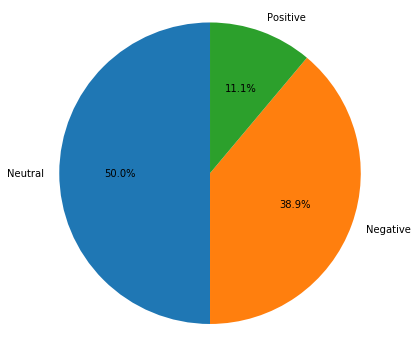

In [156]:
# Returns the count of Neutral, Negative, and Positive news headlines
count = sample['SENTIMENT_LABEL'].value_counts()

labels = 'Neutral', 'Negative', 'Positive'
sizes = [count[0], count[1], count[2]]

fig1, ax1 = plt.subplots(figsize = (6, 6))
ax1.pie(sizes, 
        labels = labels, 
        autopct = '%1.1f%%', 
        startangle = 90)

# Makes the Pie Chart round
ax1.axis('equal')

plt.show()

### Day of the Week vs. Number of Negative, Positive, and Neutral News Headlines

* Trying to find patterns
    * If the number of negative news repeats every week
* This needs to be done using all news headlines
* Group news by Date 
* Count the number of Negative and Positive news in each group
    * Count the number of Negative and Positive news in each day
* Use Line Chart to compare Negative and Positive news over time
* Two lines, one for Negative and one for Positive

In [167]:
emotions = ['negative', 'neutral', 'positive']

# Get a list of all dates, [2017-07-12, 2017-07-13, ...]
dates = list(sample.groupby('DATE').groups.keys())

# Group rows by DATE and in each group count the number of Negative, Neutral, and Positive news
date_grouped = sample.groupby('DATE').SENTIMENT_LABEL.value_counts()

# print(date_grouped['2017-07-12']['negative'])

['2017-07-12', '2017-07-13']


### Time of Day vs. Number of Negative, Positive, and Neutral News Headlines

* This needs to be done using all news headlines
* Group news by Time_of_Day 
* Count the number of Negative and Positive news in each group
    * Count the number of Negative and Positive news in the morningn day, and evening
* Use Column Chart to compare Negative and Positive in the morning, day, and evening
* Three columns, one for morning, one for day, and one for evening

### Effect of Big Celebrations on the Number of Negative, Positive, and Neutral News Headlines

* **Maybe they increased because they want people to be depressed and spend more money**

* Did they increase or decrease over the course of that week
* This needs to be done using all news headlines
* Create a new dataframe, consisting only of CBC news
* Group the new dataframe by Date and count the number of Negative and Positive news
* Use Line Chart to compare Negative and Positive news over time
* Only one line showing CBC news (would be nice to find a way to highlight the stampede week)

### The Dominant Emoition

* This needs to be done using all news headlines
* Group news by Time_of_Day 
* For every group (morning, day, evening)
    * Take the highest emotion from every headline (every row)
    * Then figure out which emotion dominates, higher the frequence --> more dominant
    * Plot a Histogram
* Plot three Histogram, one for morning, one for day, and one for evening

## Visualizations
---

* Who is the most mentioned president
    * Trump, Putin, Trudeau
    * This needs to be done using all news headlines
    * Pie  Chart
* Which country is the most mentioned
    * Russia, America, Canada, etc.
    * Bar Chart (not column chart)
* Which emotion doninates
    * Bubble Chart with bubbles being the emojis corresponding to the feeling
    * Higher the frequency bigger the bubble/emoji

### Who is the Most Famous President/Prime Minister?

To find out who is the most famous president/prime minister I summed up the `PUTIN` column, `TRUMP` column, and the `TRUDEAU` column.

As shown below, ?? is the most famous ??.

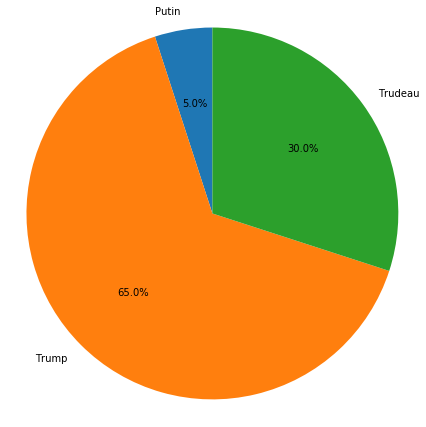

In [54]:
putin_count = sample['PUTIN'].sum()
trump_count = sample['TRUMP'].sum()
trudeau_count = sample['TRUDEAU'].sum()

labels = 'Putin', 'Trump', 'Trudeau'
sizes = [putin_count, trump_count, trudeau_count]

fig1, ax1 = plt.subplots(figsize = (6, 6))
ax1.pie(sizes, 
        labels = labels, 
        autopct = '%1.1f%%', 
        startangle = 90)

# Makes the Pie Chart round
ax1.axis('equal')

plt.tight_layout()
plt.show()

### Which Country Makes it into the News Most Often?

Since, it would be difficult to keep truck of all the different countries in a CSV file, I have decided to extract them in JSON format.

As shown below, ?? is a country that makes it into the news most often.

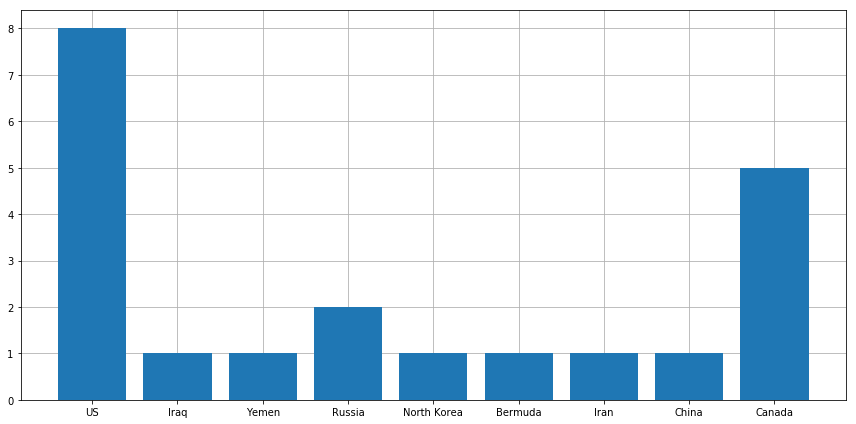

In [100]:
countries = {
  "Bermuda": 1,
  "Canada": 5,
  "China": 1,
  "Iran": 1,
  "Iraq": 1,
  "North Korea": 1,
  "Russia": 2,
  "US": 8,
  "Yemen": 1
}

y = []
x = []
labels = []

counter = 1

for country in countries:
    x.append(counter)
    counter += 1
    y.append(countries[country])
    labels.append(country)
    
fig1, ax1 = plt.subplots(figsize = (12, 6))
ax1.bar(x, y, zorder = 3)

plt.tight_layout()
plt.grid(zorder = 0)
plt.xticks(x, labels)
plt.show()